In [22]:
import numpy as np
import pandas as pd

import os
from pathlib import Path
from PIL import Image, ImageOps

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,BatchNormalization,Activation,concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
train_path = '/content/drive/MyDrive/cityscapes_data/train'
val_path = '/content/drive/MyDrive/cityscapes_data/val'

In [25]:
# Будем работать только с частью датасета

num_images_train = 80
num_images_val = 20


X_train = []
y_train = []

X_val = []
y_val = []

images_train = os.listdir(train_path)
images_val = os.listdir(val_path)

for filename in images_train[:num_images_train]:
    image = Image.open(os.path.join(train_path, filename))
    X_train.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_train.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))
    

for filename in images_val[:num_images_val]:
    image = Image.open(os.path.join(val_path, filename))
    X_val.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_val.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))


X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.

y_train = np.array(y_train)
y_val = np.array(y_val)

In [26]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((80, 256, 256, 3), (80, 256, 256, 3), (20, 256, 256, 3), (20, 256, 256, 3))

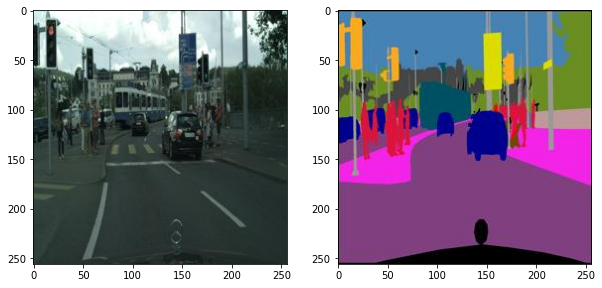

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(X_train[3])
axes[1].imshow(y_train[3])
plt.show()

Необходимо разделить маски на бинарные - по каждому классу объектов. Для этого применим кластеризацию KMeans.
По информации из просторов интернета, в датасете присуствуют 19 классов

In [28]:
y_train[1].shape

(256, 256, 3)

In [29]:
num_classes = 19
label_model = KMeans(n_clusters=num_classes, random_state=21)

#Обучим модель на части наших данных
batch = 100000
label_model.fit(y_train.reshape(-1,3)[:batch])


# num_items = 1000
# color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
# num_classes = 19
# label_model = KMeans(n_clusters=num_classes, random_state=21)
# label_model.fit(color_array)

KMeans(n_clusters=19, random_state=21)

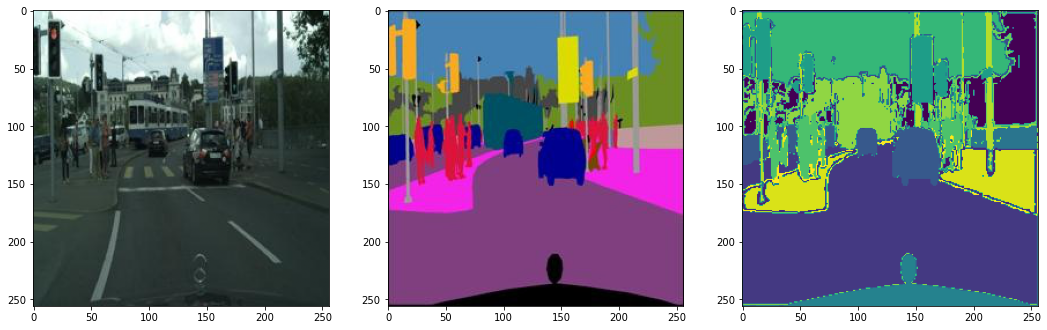

In [30]:
label_class = label_model.predict(y_train[3].reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(18, 9))
axes[0].imshow(X_train[3])
axes[1].imshow(y_train[3])
axes[2].imshow(label_class)
plt.show()

Кажется, что классификация правдопободна

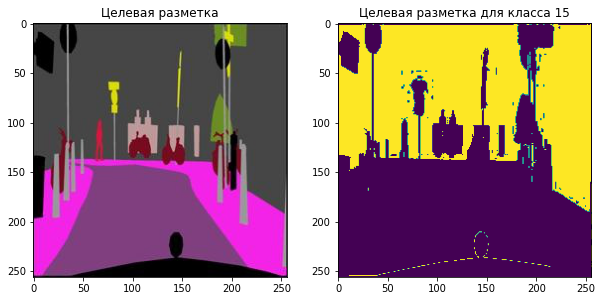

In [31]:
def Color2index(y, num_classes=19):
    arr_col = np.arange(0, num_classes)
    t = label_model.predict(y.reshape(-1, 3)).reshape(256, 256)
    y_cat = (arr_col == t[...,None]).astype(int)
    return y_cat

cat_yi = Color2index(y_train[10])

class_ = 15
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(y_train[10,:,:,:])
axes[0].title.set_text('Целевая разметка')
axes[1].imshow(cat_yi[:,:,class_])
axes[1].title.set_text(f'Целевая разметка для класса {class_}')
plt.show() 


Вроде как на первый взгляд объекты выделились вполне корректно. Теперь создадим бинарные маски по каждому классу

In [32]:
# сформируем наборы масок для обучения и валидации
train_labels_ = []
val_labels_ = []

for mask in y_train:
    y_cat = Color2index(mask)
    train_labels_.append(y_cat)

train_labels = np.array(train_labels_)

for mask in y_val:
    y_cat = Color2index(mask)
    val_labels_.append(y_cat)

val_labels = np.array(val_labels_)

**Переходим к построению нейронной сети**   

Сначала построим полностью вручную нейронную сеть по образцу с урока

In [33]:
# Введем метрику Dice Coefficient

from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [34]:
def Unet(num_classes = 19, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) 

#     # Block 4
#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
#     x = BatchNormalization()(x)
#     # запомним тензор для переноса
#     block_4_out = Activation('relu')(x)

    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [35]:
model_1 = Unet()
history = model_1.fit(X_train, train_labels, epochs=20, batch_size=1, validation_data=(X_val, val_labels))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

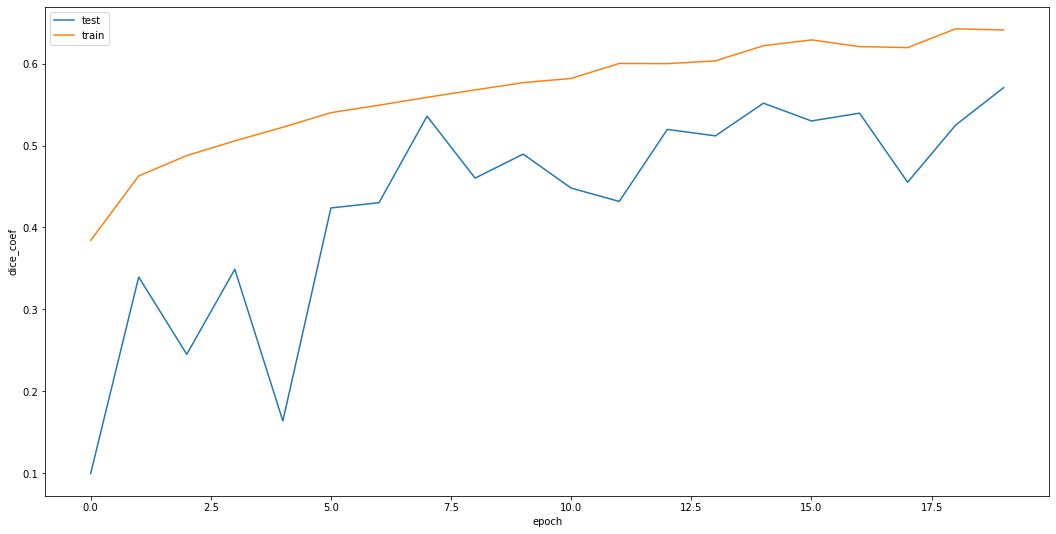

In [36]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [37]:
pred = model_1.predict(X_val)
pred.shape

(20, 256, 256, 19)

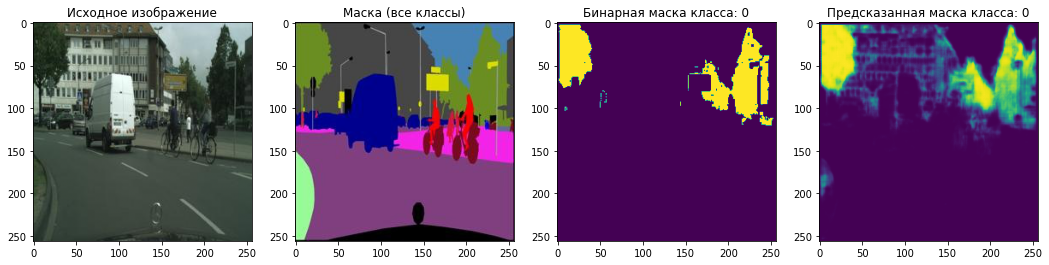

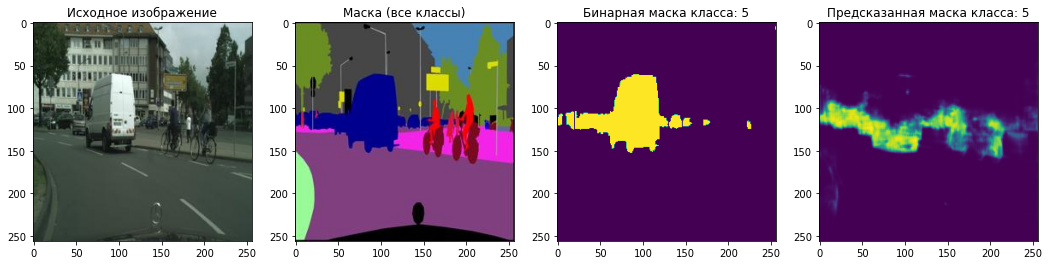

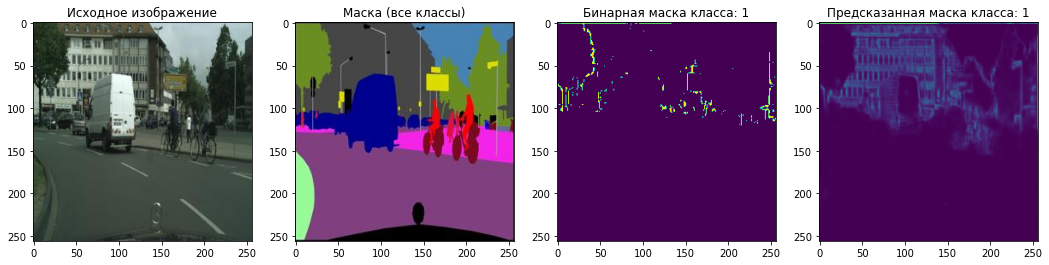

In [38]:
classes = list(np.random.randint(0, 18, 3)) # Посмотрим результат сегментации на этих классах
for class_ in classes:
    fig, axes = plt.subplots(1, 4, figsize=(18, 9))
    axes[0].imshow(X_val[5])
    axes[0].title.set_text('Исходное изображение')
    axes[1].imshow(y_val[5])
    axes[1].title.set_text('Маска (все классы)')
    axes[2].imshow(val_labels[5][:,:,class_])
    axes[2].title.set_text(f'Бинарная маска класса: {class_}')
    axes[3].imshow(pred[5][:,:,class_])
    axes[3].title.set_text(f'Предсказанная маска класса: {class_}')
    plt.show()

**Теперь построим нейронную сеть для сегметнации на основе предобученной нейронной сети ResNet**

In [54]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [55]:
pre_trained_model = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Зафиксируем слои для симметричного разжатия картинки при реализации Unet-a в порядке сжатия (из преобученной модели):  
* По рекомендации с вебинара зафиксируем слои, где происходит активация  
5 -  conv1_relu (Activation) (128, 128 , 64)  
4 - conv2_block3_out (Activation)  (64, 64, 256)    
3 - conv3_block4_out (Activation) (32, 32, 512)   
2 - conv4_block6_out (Activation) (16, 16, 1024)   
1 - conv5_block1_2_relu (Activation) (8, 8, 512)   


Важно помнить, что пристыковывать слои надо слоям на одном уровне

In [56]:
# сохраненного состояния в исходном размере не делаем, т к в resnet сразу же идет сжатие
# conv1 = pre_trained_model.get_layer('conv1_relu').output  # (128, 128, 64)
# conv2 = pre_trained_model.get_layer('conv2_block3_out').output  # (64, 64, 256)
# conv3 = pre_trained_model.get_layer('conv3_block1_1_relu').output  # (32, 32, 128)
# conv4 = pre_trained_model.get_layer('conv4_block2_2_relu').output  # (16, 16, 256)
# conv5 = pre_trained_model.get_layer('conv5_block1_2_relu').output  # (8, 8, 512)

conv1 = pre_trained_model.get_layer('conv1_relu').output  # (128, 128, 64)
conv2 = pre_trained_model.get_layer('conv2_block3_out').output  # (64, 64, 256)
conv3 = pre_trained_model.get_layer('conv3_block4_out').output  # (32, 32, 512)
conv4 = pre_trained_model.get_layer('conv4_block6_out').output  # (16, 16, 1024)
conv5 = pre_trained_model.get_layer('conv5_block1_2_relu').output  # (8, 8, 512)

print(conv1)
print(conv2)
print(conv3)
print(conv4)
print(conv5)


KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='conv1_relu/Relu:0', description="created by layer 'conv1_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='conv2_block3_out/Relu:0', description="created by layer 'conv2_block3_out'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='conv3_block4_out/Relu:0', description="created by layer 'conv3_block4_out'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1024), dtype=tf.float32, name=None), name='conv4_block6_out/Relu:0', description="created by layer 'conv4_block6_out'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 512), dtype=tf.float32, name=None), name='conv5_block1_2_relu/Relu:0', description="created by layer 'conv5_block1_2_relu'")


In [57]:
# Создадим модель

def unet_with_resnet_pretrain(num_classes=19, input_shape=(256, 256, 3)):    
    pre_trained_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    img_input = pre_trained_model.inputs
    
    for layer in pre_trained_model.layers[:-10]:
        layer.trainable = False
    
    conv1 = pre_trained_model.get_layer('conv1_relu').output  # (128, 128, 64)
    conv2 = pre_trained_model.get_layer('conv2_block3_out').output  # (64, 64, 256)
    conv3 = pre_trained_model.get_layer('conv3_block4_out').output  # (32, 32, 512)
    conv4 = pre_trained_model.get_layer('conv4_block6_out').output  # (16, 16, 1024)
    conv5 = pre_trained_model.get_layer('conv5_block1_2_relu').output  # (8, 8, 512)
    x = conv5 #это будет "дном", откуда будем разворачивать картинку к исходному размеру

    # UP 1
    
    # Шаг разжатия 
    x = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(x) #становится 16х16 и 1024 канала
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Присоединяем результат слоя сжатия этого же уровня (skip connection) - перенос из понижаюшего плеча
    x = concatenate([x, conv4])
    
    # Дополнительно уточняем границы изобрадения
    x = Conv2D(1024, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1024, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) #становится 32х32 и 512 канала
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, conv3])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)  #становится 128x128 и 256 каналов
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, conv2])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x) # становится 128х128 и 64 канала
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, conv1])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 5
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x) # становится 256x256 и 64 канала
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # слой классификатор
    x = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

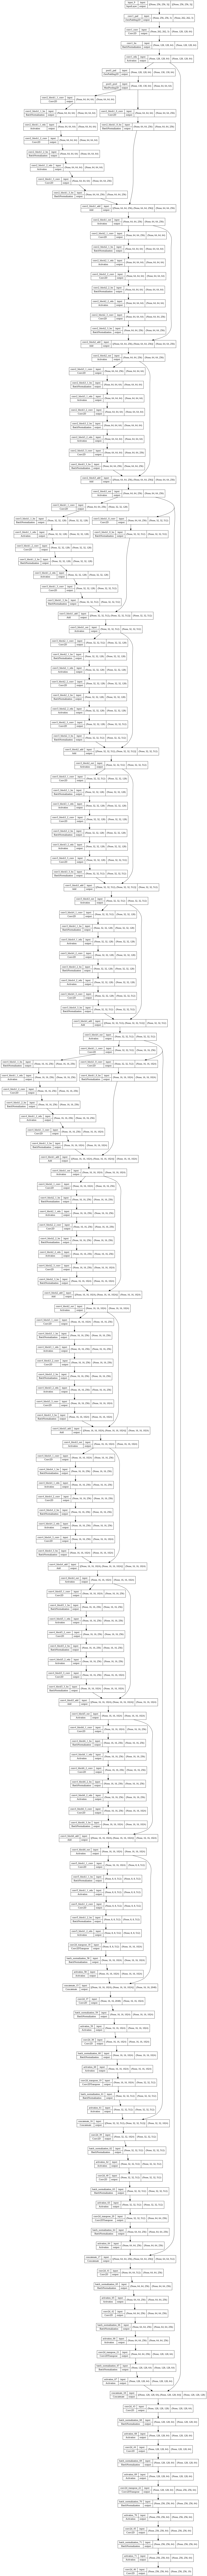

In [58]:
num_classes = 19
model_2 = unet_with_resnet_pretrain(num_classes, (256, 256, 3))

plot_model(model_2, show_shapes=True)

In [59]:
X_tr = []
X_v = []

for filename in images_train[:num_images_train]:
    image = Image.open(os.path.join(train_path, filename))
    X_tr.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    

for filename in images_val[:num_images_val]:
    image = Image.open(os.path.join(val_path, filename))
    X_v.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))

In [60]:
X_tr = preprocess_input(np.array(X_tr))
X_v = preprocess_input(np.array(X_v))

In [61]:
history = model_2.fit(X_tr, train_labels, epochs=25, batch_size=1, validation_data=(X_v, val_labels))

Epoch 1/25
80/80 [==============================] - 26s 263ms/step - loss: 1.6415 - dice_coef: 0.3886 - val_loss: 3.5254 - val_dice_coef: 0.2713
Epoch 2/25
80/80 [==============================] - 20s 244ms/step - loss: 1.1349 - dice_coef: 0.5426 - val_loss: 2.5306 - val_dice_coef: 0.5469
Epoch 3/25
80/80 [==============================] - 19s 234ms/step - loss: 0.9743 - dice_coef: 0.6003 - val_loss: 1.6787 - val_dice_coef: 0.6050
Epoch 4/25
80/80 [==============================] - 20s 245ms/step - loss: 0.8828 - dice_coef: 0.6437 - val_loss: 1.1089 - val_dice_coef: 0.6713
Epoch 5/25
80/80 [==============================] - 19s 235ms/step - loss: 0.8435 - dice_coef: 0.6570 - val_loss: 1.4541 - val_dice_coef: 0.6410
Epoch 6/25
80/80 [==============================] - 19s 235ms/step - loss: 0.7682 - dice_coef: 0.6868 - val_loss: 1.6962 - val_dice_coef: 0.6006
Epoch 7/25
80/80 [==============================] - 20s 244ms/step - loss: 0.7490 - dice_coef: 0.6974 - val_loss: 1.1333 - val_dic

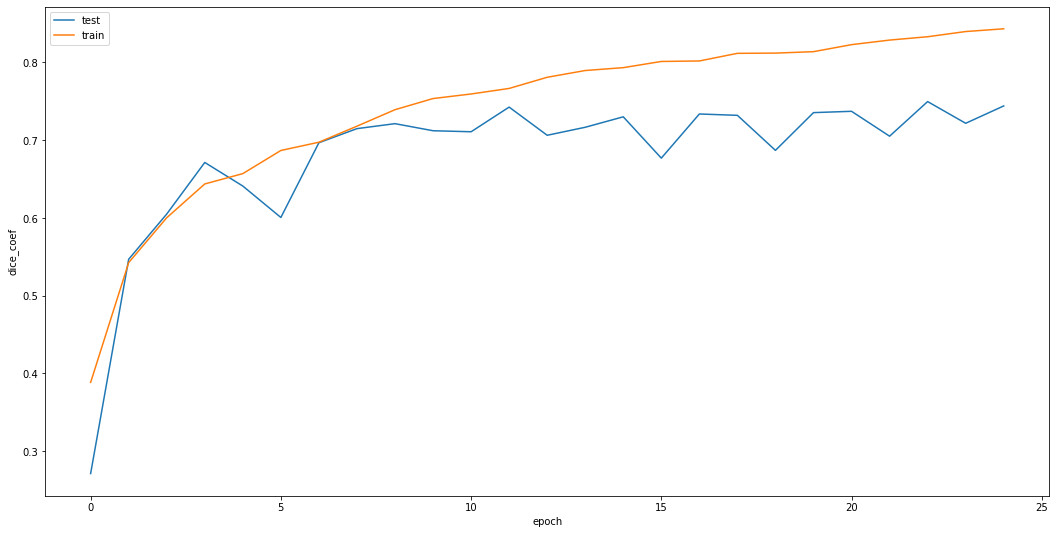

In [62]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [63]:
pred = model_2.predict(X_v)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


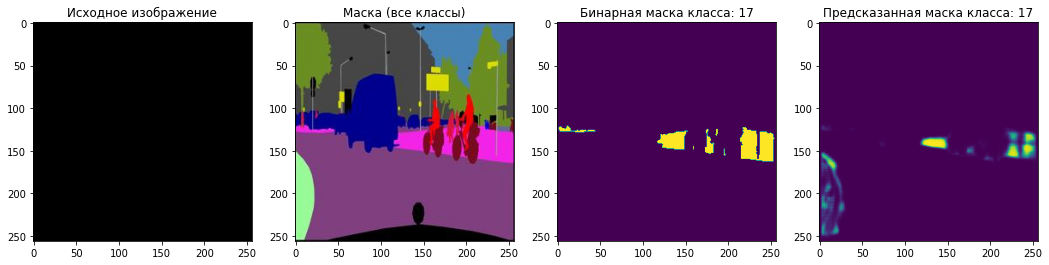

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


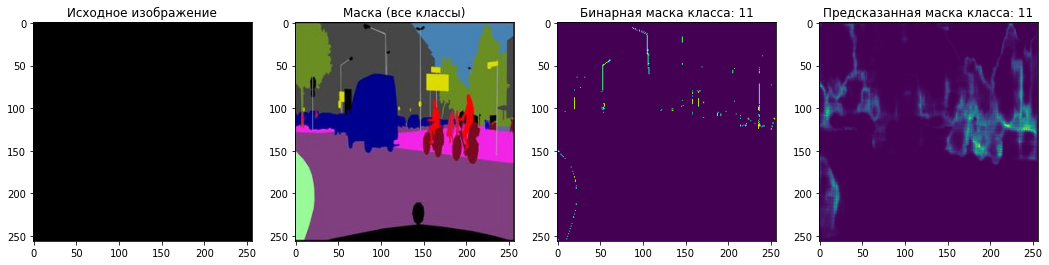

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


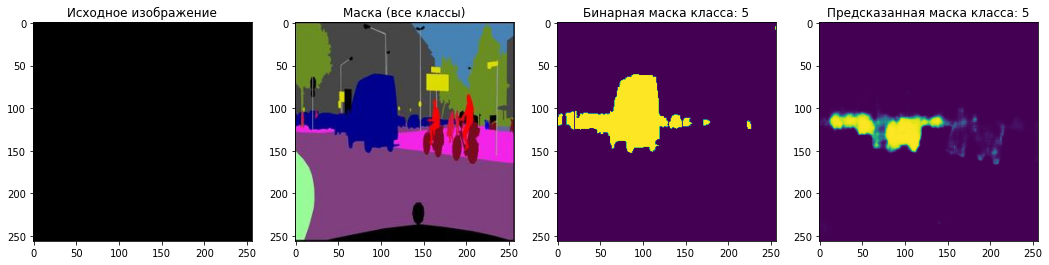

In [64]:
classes = list(np.random.randint(0, 18, 3)) # Посмотрим результат сегментации на этих классах
for class_ in classes:
    fig, axes = plt.subplots(1, 4, figsize=(18, 9))
    axes[0].imshow(X_val[5])
    axes[0].title.set_text('Исходное изображение')
    axes[1].imshow(y_val[5])
    axes[1].title.set_text('Маска (все классы)')
    axes[2].imshow(val_labels[5][:,:,class_])
    axes[2].title.set_text(f'Бинарная маска класса: {class_}')
    axes[3].imshow(pred[5][:,:,class_])
    axes[3].title.set_text(f'Предсказанная маска класса: {class_}')
    plt.show()

Улучшить метрику помогло:  
* выбор разных слоев сохранений состояний. 
* разное количество слоев на каждом уровне
* симметрия конкатенации (по уровням сохранение одинакового количества слоев)
* использование предобученной модели ResNet позволило получить частично более стабильный результат